origin: http://pytorch.org/tutorials/advanced/neural_style_tutorial.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline
from __future__ import print_function, division

# 用PyTorch实现神经风格
## 1. 介绍
本教程将解释如何实现由Leon A. Gatys, Alexander S. Ecker and Matthias Bethge开发的[神经风格](https://arxiv.org/abs/1508.06576)算法。

### 1.1 神经什么？
神经风格或神经迁移是一种算法，该算法的输入是一张内容图像（例如一只乌龟）和一张风格图像（带有艺术造型的波浪），输出的图像具有内容图像的内容和风格图像的艺术风格：
![](imgs/neuralstyle.png)

### 1.2 如何工作
神经风格的工作原理非常简单：定义两个距离，一个表示内容距离（$D_C$），另一个表示风格距离（$D_S$）。$D_C$测量两幅图像内容之间的差异，而$D_S$测量两幅图像风格上的差异。然后我们对输入图像（带噪声的图像）进行变换，变换的目的是同时最小化与内容图像的内容距离和与风格图像的风格距离。

### 1.3 到底如何工作
接下来的解释需要一些数学。令$C_{nn}$为提前训练好的深度卷积网络，$X$为任意一张图像。则$C_{nn}(X)$表示网络的输入为$X$（$C_{nn}$包含了所有层的特征图）。令$F_{XL} \in C_{nn}(X)$，表示将第$L$层所有的特征图向量化并拼接为一个向量。我们简单的定义$L$层$X$的内容为$F_{XL}$。然后，如果$Y$是另外一幅与$X$大小相同的图像，我们定义在$L$层的内容距离为：
$$D^L_C(X,Y) = \| F_{XL} - F_{YL}\|^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2$$
其中$F_{XL}(i)$是$F_{XL}$的第$i$个元素。

风格距离的定义稍有点琐碎。设第$L$层共有$K$个特征图，$F^k_{XL}$表示第$L$层第$k$个特征图向量化后的表示。图像$X$在第$L$层的风格$G_{XL}$被定义为所有向量化的特征图的**Gram product**，其中$k \leq K$。也就是说，$G_{XL}$是一个$K \times K$的矩阵，元素$G_{XL}(k, l)$是矩阵$G_{XL}$的第$k$行、第$l$列的元素，是$F^k_{XL}$和$F^l_{XL}$的向量积：
$$G_{XL}(k,l)= \langle F^k_{XL}, F^l_{XL} \rangle = \sum_i F^k_{XL}(i) . F^l_{XL}(i)$$
其中$F^k_{XL}(i)$是$F^k_{XL}$的第$i$个元素。我们可以看到$G_{XL}(k,l)$是特征图$k$和$l$的相关。因此，$G_{XL}$表示了第$L$层$X$的特征图的相关矩阵。注意，$G_{XL}$的大小依赖于该层特征图的数量，而与$X$无关。因此$Y$可以是任何大小的另一幅图像。我们定义$L$层的风格距离为：
$$D^L_S(X,Y)= \| G_{XL} - G_{YL} \|^2 = \sum_{k,l}(G_{XL}(k,l) - G_{YL}(k,l))^2$$

为了同时最小化变量图像$X$与目标内容图像$C$之间的内容距离$D_X(X,C)$和$X$与目标风格图像$S$的风格距离$D_S(X,S)$，同时计算若干层的距离，然后将每一层的距离关于$X$的梯度进行求和：
$$\nabla_{total}(X,S,C) = \sum_{L_C}w_{CL_C} . \nabla^{L_C}_{content}(X, C) + 
\sum_{L_S} w_{SL_S} . \nabla^{L_S}_{style}(X,S)$$
其中$L_C$和$L_S$分别为内容和风格分别需要的层，$w_{CL_C}$和$w_{SL_S}$分别为与需要的内容和风格层相关的权重（可任意指定）。然后我们对$X$执行梯度下降算法：
$$X \leftarrow X - \alpha \nabla_{total}(X,S,C)$$

这就是理解神经风格所需的数学。如果你需要深的理解梯度是如何计算的，我们鼓励你去阅读**Leon A. Gatys and AL**所写的原文，其中有更好、更清楚的解释。

对于要在PyTorch中实现神经风格，以上内容已经足够了。由于在PyTorch中，所有的梯度都可以自动动态的计算（当你使用库函数的时候）。这就是为什么用PyTorch实现这一算法非常舒适的原因。

## 2. 用PyTorch实现
如果你还没有理解上面的数学内容，你可能能够从实现的过程中来理解它。

### 2.1 用到的包
我们将使用以下包来实现神经风格：
- **torch**、**torch.nn**、**numpy**（用PyTorch实现神经网络不可缺少的包）
- **torch.autograd.Variable**（用来动态计算关于变量的梯度）
- **torch.optim**（高效的梯度下降算法）
- **PIL**、**PIL.Image**、**matplotlib.pyplot**（加载和显示图像）
- **torchvision.transforms**（处理PIL图像并将其变换为torch的张量）
- **torchvision.models**（训练或加载与训练模型）
- **copy**（系统包，用于深拷贝模型）

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

### 2.2 Cuda
如果你的计算机拥有GPU，推荐在GPU上运行算法，尤其是如果你需要使用大型网络（例如VGG）。如果你的计算机拥有GPU，那么**torch.cuda.is_available()**将返回**True**。然后我们就可以使用**.cuda()**方法，将与模块相关的内存分配进程有CPU迁移到GPU。当我们想要将模块从GPU迁移回CPU（例如要使用numpy），可以用**.cpu()**方法。最后，**.type(dtype)**将**torch.FloatTensor**转换为**torch.cuda.FloatTensor**以用于GPU处理。

In [3]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

### 2.3 加载图像
为了简化实现，让我们首先加载具有想同维度的风格图像和内容图像。然后将它们缩放为输出图像的尺寸（依赖于是否存在GPU，将使用128或215的尺寸），然后将他们变换为张量，接着输入到神经网络中：

> **注意**
> 本教程需要的两张图像可以在此处下载：[picasso.jpg](http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg)和[dancing.jpg](http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg)。将这两幅图像下载到名为**images**的目录中。

In [4]:
# 输出图像的尺寸
imsize = 512 if use_cuda else 128 # 如果没有GPU就用小一点的尺寸

loader = transforms.Compose([
    transforms.Resize(imsize), #缩放图像
    transforms.ToTensor()]) # 将图像变换为张量

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # 添加一个假的批量维度，以满足网络的输入的需要
    image = image.unsqueeze(0)
    return image

style_img = image_loader('images/picasso.jpg').type(dtype)
content_img = image_loader('images/dancing.jpg').type(dtype)

assert style_img.size() == content_img.size(), \
    "我们需要内容和风格图像具有相同的大小"

输入的PIL图像的值在0到255之间。变换之后的张量的值在0到1之间。这是一个重要的细节：Torch库中的神经网络是用0-1张量图像训练的。如果尝试将值为0-255的张量图像输入网络，特征激活图将没有任何含义。这与Caffe库中的预训练网络不同，Caffe中的网络是用0-255的张量图像训练的。

### 2.4 显示图像
我们将使用**plt.imshow**来显示图像。因此我们需要首先将他们转换为PIL图像：

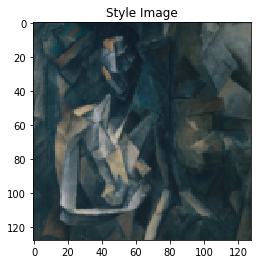

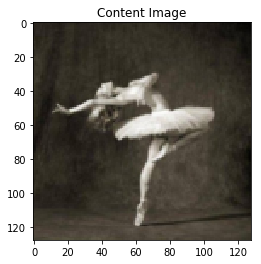

In [5]:
unloader = transforms.ToPILImage() # 重新转换为PIL图像

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu() # 将张量拷贝过来，不影响原始图像
    image = image.view(3, imsize, imsize) # 去掉假的批量维度
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 暂停一会等待绘图更新
    
plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

### 2.5 内容损失
内容损失是一个用于计算输入图像和内容图像之间带权重的内容距离$w_{CL} . D^L_C(X,C)$的函数，其中$F_{XL}$表示网络输入为$X$时在第$L$层所得到的的特征图。因此，权重$w_{CL}$和目标内容$F_{CL}$是该函数的参数。我们用torch中的**module**来实现该函数，并用上述参数来构造类。距离$\| F_{XL} - F_{YL} \|^2$是两组特征图之间的平均平方误差，该误差可用评估函数**nn.MSELoss**来表示，并将其作为第三个参数。

我们将把内容损失作为附加模块添加在所关注的神经网络层。这样，每次我们将输入图像$X$送入网络，所有的期待层的内容损失会被同时计算，同时由于自动梯度的机制，所有的梯度也会被同时计算。因此，我们只需要编写模块的**forward**方法：模块变成了一个神经网络的一个“透明层”。计算出来的损失作为模块的一个参数。

最后，我们定一个一个假的**backward**方法，只是为了重建梯度而调用**nn.MSELoss**的backward方法。该方法返回计算出来的损失：这在显示梯度下降过程中风格和内容损失进化非常有用。

In [6]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 从树上detach目标内容
        self.target = target.detach() * weight
        # 为了动态计算梯度：这是一个指定的值，而不是一个变量。
        # 否则，标准函数在执行前馈方法时会抛出错误。
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

> **注意**
> **重要的细节：**上面的模块，尽管叫做**ContentLoss**，但是不是一个真的PyTorch损失函数。如果想要把内容损失定义为一个PyTorch损失，需要创建一个PyTorch的**autograd Function**，然后手工在**backward**方法中重新计算或实现梯度。

### 2.6 风格损失
对于风格损失，我们首先需要定义一个模块用来计算网络输入为$X$时，第$L$层特征图$F_{XL}$的**gram积**$G_{XL}$。令$\hat F_{XL}$为$F_{XL}$重塑为$K \times N$的矩阵，其中$K$是$L$层特征图的通道数，$N$是特征图$F^k_{XL}$向量化后的长度。$\hat F_{XL}$的第$k$行是$F^k_{XL}$。我们使用公式$\hat F_{XL} . \hat F^T_{XL} = G_{XL}$来实现下面的模块：

In [7]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size() 
        # a是批量的尺寸（=1）
        # b是特征通道数
        # （c, d）是特征图的维度（N=c*d）
        
        features = input.view(a * b, c * d) # 将F_XL重塑为 \hat F_XL
        
        G = torch.mm(features, features.t()) # 计算gram积
        
        # 我们通过除以每个特征图中的元素数来“归一化”gram矩阵
        return G.div(a * b * c * d)

特征图的维度$N$越大，gram矩阵的值也就越大。因此，如果不用$N$进行归一化，则在第一层（池化之前）将在梯度下降的过程中更为重要。我们并不希望这样，由于更深的层拥有最有趣的风格。

然后风格损失就可以和内容损失类似的方式进行定义，**gramMatrix**将作为它的一个参数：

In [8]:
class StyleLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

### 2.7 加载神经网络
现在，我们将要导入预训练的神经网络。与论文一致，我们将使用预训练的19层VGG（VGG19）。

PyTorch中实现的VGG模块包含两个子**Sequential**模型：
- **features**（包含卷积和池化层）
- **classifier**（包含全连接层）
我们只对**features**层感兴趣：

In [9]:
cnn = models.vgg19(pretrained=True).features

# 如果可能迁移到GPU
if use_cuda:
    cnn = cnn.cuda()

一个**Sequential**模块包含由子模块构成的有序列表。例如**vgg19.features**包含了一个按照深度排列的序列（Conv2d, ReLU, Maxpool2d, Conv2d, ReLU...）。正如我们在内容损失小节中所说，我们需要将我们自己的风格和内容损失附加到希望的层，作为“透明”层。为了实现这一点，我们要从**vgg19**中添加模块到一个新建**Sequential**模块中，同时我们的损失模块也要拥有正确的顺序：

In [10]:
# 需要计算风格/内容损失的层：
content_layers_default = ['conv_4']
style_layers_defualt = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_defualt):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential() # 新的序列模型网络
    gram = GramMatrix() # 我们需要gram模块来计算风格目标
    
    # 如果可能将模型迁移到GPU
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
        
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # 添加内容损失
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
                
            if name in style_layers:
                # 添加风格损失
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # 添加内容损失
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
                
            if name in style_layers:
                # 添加风格损失
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
            i += 1
        
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)
    
    return model, style_losses, content_losses

> **注意**
> 在论文中，他们推荐将最大池改为平均池。由于AlexNet相比于VGG19是一个小型网络，我们看不到结果之间的任何差别。然而，你可以使用下面的代码来进行置换：
``` Python
avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size,
                stride=layer.stride, padding=layer.padding)
model.add_module(name, avgpool)
```

### 2.8 输入图像
为了简化代码，我们选择与内容和风格图像相同维度的输入图像。该图像可以是一个白噪声，也可以是内容图像的拷贝。

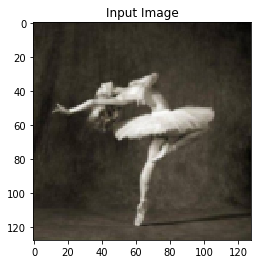

In [11]:
input_img = content_img.clone()
# 如果想使用白噪声作为输入图像，将下面的行注释去掉
# input_img = Variable(torch.randn(content_img.size())).type(dtype)

# 添加原始图像到图表上
plt.figure()
imshow(input_img.data, title='Input Image')

### 2.9 梯度下降
如算法的作者Leon Gatys所建议（[这里](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)）,我们将使用L-BFGS算法来运行梯度下降。与训练网络不同，我们要训练的是输入图像，优化的目标是最小化内容和风格损失。我们可以简单的创建PyTorch的L-BFGS优化器，将图像作为变量传入以进行优化。但是**optim.LBFGS**的第一个参数是一个PyTorch需要计算梯度的**Variable**列表。我们的输入图像是一个**Variable**，但不是需要计算梯度的树中的节点。一种方式就是由输入图像构建**Parameter**对象。然后给定一个包含该**Parameter**的列表传递给优化器的构造函数：

In [12]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

**最后一步：**循环执行梯度下降。在每一步，我们必须将更新后的输入传入到网络中以计算新的损失，我们必须运行每一个损失的**backward**方法来计算梯度，并执行梯度下降步。优化器需要“闭合”参数：该函数重新计算模型并返回损失。

然而，还有一个小问题。优化后的图像的取值为$-\infty$到$\infty$，而不是从0到1。也就是说最有的图像可能有着荒谬的值。实际上，我们必须在约束下执行优化以保持输入图像拥有正确的值。有一个最简单的解决方案，在每一步，修正图像保持它的值在0-1区间。

In [13]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """运行风格迁移"""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # 修正更新输入图像
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
            
            for s1 in style_losses:
                style_score += s1.backward()
            for c1 in content_losses:
                content_score += c1.backward()
            
            run[0] += 1
            if run[0] % 10 == 0:
                print('run {}'.format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    # 最后的修正
    input_param.data.clamp_(0, 1)
    
    return input_param.data

最后，运行算法：

Building the style transfer model..
Optimizing..
run [10]
Style Loss : 5.986490 Content Loss: 0.780418

run [20]
Style Loss : 2.489463 Content Loss: 1.003724

run [30]
Style Loss : 1.618755 Content Loss: 0.992745

run [40]
Style Loss : 1.143479 Content Loss: 0.987662

run [50]
Style Loss : 0.775400 Content Loss: 0.992851

run [60]
Style Loss : 0.502575 Content Loss: 0.985675

run [70]
Style Loss : 0.367784 Content Loss: 0.946990

run [80]
Style Loss : 0.299989 Content Loss: 0.918630

run [90]
Style Loss : 0.279862 Content Loss: 0.889096

run [100]
Style Loss : 0.268278 Content Loss: 0.862912

run [110]
Style Loss : 0.257550 Content Loss: 0.847879

run [120]
Style Loss : 0.250302 Content Loss: 0.837188

run [130]
Style Loss : 0.240876 Content Loss: 0.831128

run [140]
Style Loss : 0.233020 Content Loss: 0.826121

run [150]
Style Loss : 0.227337 Content Loss: 0.821762

run [160]
Style Loss : 0.222347 Content Loss: 0.817608

run [170]
Style Loss : 0.219321 Content Loss: 0.813336

run [180

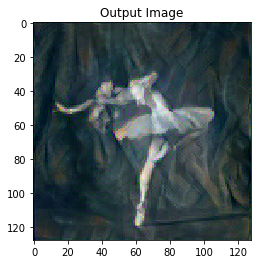

In [14]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()